In [1]:
# Import required packages
import os

import pandas as pd
import earthpy as et
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import earthpy.plot as ep
import h5py
import json
import requests
from shapely.geometry import box
import seaborn as sns
from sklearn.neighbors import KernelDensity
import matplotlib.gridspec as grid_spec


# Set working directory
directory_path = os.path.join(et.io.HOME, "earth-analytics")
os.chdir(directory_path)

# Download the data
et.data.get_data(url="https://storage.googleapis.com/neon-aop-products/2020/FullSite/D13/2020_NIWO_4/L3/Spectrometer/Reflectance/NEON_D13_NIWO_DP3_454000_4432000_reflectance.h5")

In [2]:
# Create path to hdf5 file
hdf5_path = os.path.join("data", "earthpy-downloads", "NEON_D13_NIWO_DP3_454000_4432000_reflectance.h5")

In [3]:
def aop_h5refl2array(refl_filename):
    """aop_h5refl2array reads in a NEON AOP reflectance hdf5 file and returns 
           1. reflectance array (with the no data value and reflectance scale factor applied)
           2. dictionary of metadata including spatial information, and wavelengths of the bands
    --------
    Parameters
        refl_filename -- full or relative path and name of reflectance hdf5 file
    --------
    Returns 
    --------
    reflArray:
        array of reflectance values
    metadata:
        dictionary containing the following metadata:
            bad_band_window1 (tuple)
            bad_band_window2 (tuple)
            bands: # of bands (float)
            data ignore value: value corresponding to no data (float)
            epsg: coordinate system code (float)
            map info: coordinate system, datum & ellipsoid, pixel dimensions, and origin coordinates (string)
            reflectance scale factor: factor by which reflectance is scaled (float)
            wavelength: wavelength values (float)
            wavelength unit: 'm' (string)
    """
    
    # Read in reflectance hdf5 file 
    hdf5_file = h5py.File(refl_filename,'r')

    # Get the site name
    file_attrs_string = str(list(hdf5_file.items()))
    file_attrs_string_split = file_attrs_string.split("'")
    sitename = file_attrs_string_split[1]
    
    # Extract the reflectance & wavelength datasets
    refl = hdf5_file[sitename]["Reflectance"]
    reflData = refl["Reflectance_Data"]
    reflRaw = refl["Reflectance_Data"][:]
    
    # Create dictionary containing relevant metadata information
    metadata = {}
    metadata["wavelength"] = refl["Metadata"]["Spectral_Data"]["Wavelength"]

    # Extract no data value & scale factor
    metadata['data ignore value'] = float(reflData.attrs['Data_Ignore_Value'])
    metadata['reflectance scale factor'] = float(reflData.attrs['Scale_Factor'])
    
    # Apply no data value
    reflClean = reflRaw.astype(float)
    arr_size = reflClean.shape
    if metadata["data ignore value"] in reflRaw:
        print("% No Data: ",np.round(np.count_nonzero(reflClean==metadata["data ignore value"])*100/(arr_size[0]*arr_size[1]*arr_size[2]),1))
        nodata_ind = np.where(reflClean==metadata["data ignore value"])
        reflClean[nodata_ind]=np.nan 
    
    # Apply scale factor
    reflArray = reflClean/metadata["reflectance scale factor"]
    
    # Extract spatial extent from attributes
    metadata["spatial extent"] = reflData.attrs["Spatial_Extent_meters"]
    
    # Extract bad band windows
    metadata["bad band window1"] = (refl.attrs["Band_Window_1_Nanometers"])
    metadata["bad band window2"] = (refl.attrs["Band_Window_2_Nanometers"])
    
    # Extract map information: spatial extent & resolution (pixel size)
    mapInfo = refl["Metadata"]["Coordinate_System"]["Map_Info"]
    
    hdf5_file.close        
    
    return reflArray, metadata

In [4]:
# Read in file and save reflectance data to a variable
niwo_refl, niwo_refl_md = aop_h5refl2array(hdf5_path)

In [5]:
print(niwo_refl)

[[[0.     0.0099 0.0076 ... 0.     0.     0.    ]
  [0.     0.0026 0.0032 ... 0.     0.     0.    ]
  [0.0777 0.0037 0.0018 ... 0.     0.     0.    ]
  ...
  [0.0168 0.0213 0.0138 ... 0.0195 0.0128 0.0143]
  [0.0205 0.0338 0.0167 ... 0.0498 0.0406 0.0348]
  [0.0137 0.0281 0.0124 ... 0.0339 0.0311 0.0285]]

 [[0.     0.0036 0.0002 ... 0.     0.     0.    ]
  [0.     0.0055 0.0086 ... 0.0009 0.     0.    ]
  [0.0706 0.0276 0.0025 ... 0.0017 0.0038 0.    ]
  ...
  [0.0171 0.0195 0.0088 ... 0.0072 0.0087 0.0035]
  [0.0046 0.0163 0.0099 ... 0.0099 0.0091 0.0065]
  [0.0944 0.0221 0.021  ... 0.0125 0.0133 0.0078]]

 [[0.0061 0.0033 0.0051 ... 0.     0.     0.    ]
  [0.0098 0.0002 0.0102 ... 0.     0.     0.    ]
  [0.0714 0.012  0.0154 ... 0.001  0.     0.0002]
  ...
  [0.0333 0.0182 0.0131 ... 0.0056 0.0055 0.0061]
  [0.1043 0.0253 0.0142 ... 0.0042 0.     0.0033]
  [0.14   0.0168 0.0163 ... 0.0051 0.001  0.    ]]

 ...

 [[0.004  0.0184 0.0078 ... 0.0011 0.     0.0015]
  [0.1339 0.0135 0.0

In [6]:
print(niwo_refl_md)

{'wavelength': <HDF5 dataset "Wavelength": shape (426,), type "<f4">, 'data ignore value': -9999.0, 'reflectance scale factor': 10000.0, 'spatial extent': array([ 454000.,  455000., 4432000., 4433000.]), 'bad band window1': array([1340, 1445]), 'bad band window2': array([1790, 1955])}


In [7]:
# Loop through reflectance array to calculate mean reflectance for each band
# Create empty list
reflectance = []
for band in np.arange(niwo_refl.shape[2]):
        refl_band = niwo_refl[:,:,band]
        refl_mean = refl_band.mean()
        reflectance.append(refl_mean)

In [8]:
niwo_refl.shape

(1000, 1000, 426)

In [9]:
 np.arange(niwo_refl.shape[2])

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [10]:
# Assign wavelength data to a variable
wavelengths = niwo_refl_md["wavelength"]

In [11]:
# Print min and max wavelength values
print('min wavelength:', np.amin(wavelengths),'nm')
print('max wavelength:', np.amax(wavelengths),'nm')

min wavelength: 381.667 nm
max wavelength: 2510.0774 nm


In [12]:
# Create pandas dataframe for plotting
refl_df = pd.DataFrame()
refl_df["wavelength"] = wavelengths
refl_df["reflectance"] = reflectance
refl_df

,wavelength,reflectance
0,381.666992,0.034503
1,386.674988,0.022135
2,391.683014,0.019015
3,396.691101,0.019928
4,401.699097,0.018717
...,...,...
421,2490.045410,0.015688
422,2495.053223,0.019516
423,2500.061279,0.020172
424,2505.069336,0.017080


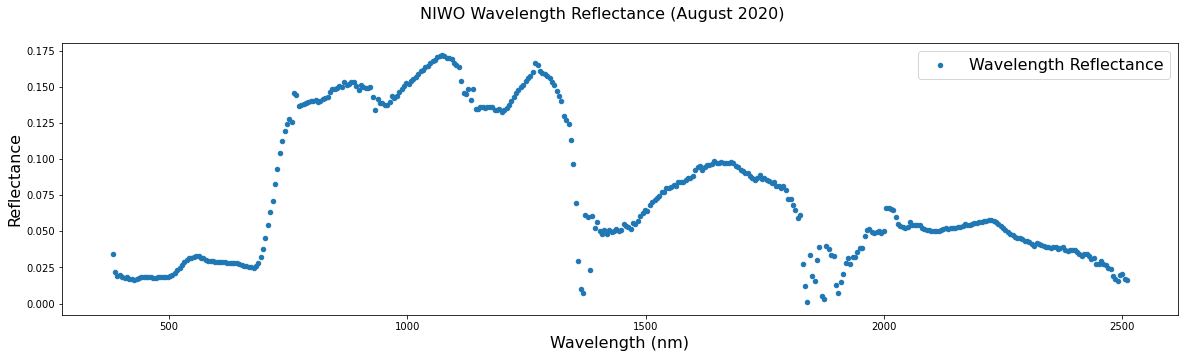

In [13]:
# Define figure space
fig, ax = plt.subplots(figsize=(20, 5))

# Plot wavelength
refl_df.plot(ax=ax, 
             x="wavelength",
             y="reflectance",
             kind="scatter", 
             label="Wavelength Reflectance",
             legend=True)

# Set title
fig.suptitle("NIWO Wavelength Reflectance (August 2020)", fontsize=16)

# Set x and y axis labels
plt.xlabel("Wavelength (nm)", fontsize=16)
plt.ylabel("Reflectance", fontsize=16)

# Add legend
ax.legend(prop={'size': 16})

In [14]:
# Make boxes to overlay on waveform image that represent bands picked up by MicaSense
# Create boxes with box(minx, miny, maxx, maxy)
box_1 = box(444, 0.005, 472, 0.035)
box_2 = box(475, 0.005, 507, 0.035)
box_3 = box(531, 0.02, 545, 0.05)
box_4 = box(560, 0.02, 587, 0.05)
box_5 = box(650, 0.01, 666, 0.04)
box_6 = box(668, 0.01, 682, 0.04)
box_7 = box(705, 0.04, 715, 0.09)
box_8 = box(717, 0.05, 729, 0.1)
box_9 = box(740, 0.115, 758, 0.135)
box_10 = box(842, 0.135, 899, 0.165)

In [15]:
# Create list of boxes
box_list = [box_1, box_2, box_3, box_4, box_5, box_6, box_7, box_8, box_9, box_10]

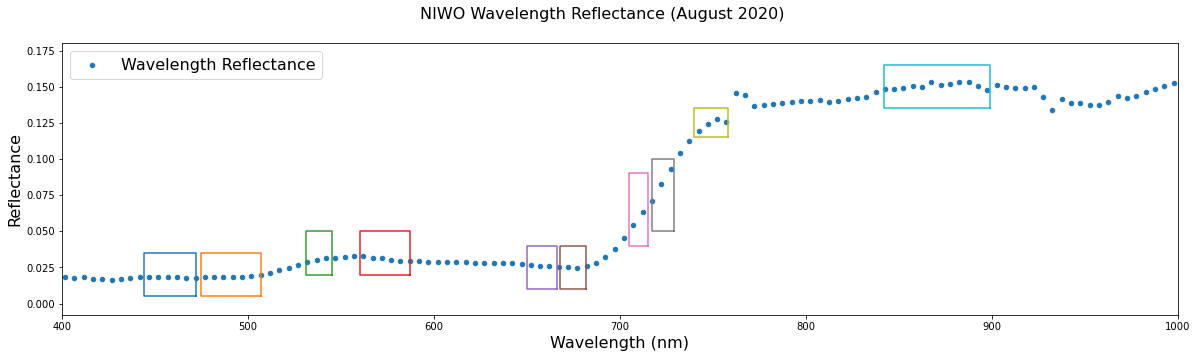

In [16]:
# Define figure space
fig, ax = plt.subplots(figsize=(20, 5))

# Plot wavelength
refl_df.plot(ax=ax, 
             x="wavelength",
             y="reflectance",
             kind="scatter", 
             label="Wavelength Reflectance",
             legend=True)

# Set title
fig.suptitle("NIWO Wavelength Reflectance (August 2020)", fontsize=16)

# Set x and y axis labels
plt.xlabel("Wavelength (nm)", fontsize=16)
plt.ylabel("Reflectance", fontsize=16)

# Add legend
ax.legend(prop={'size': 16})

# Restrict x-axis limits
ax.set_xlim([400, 1000])

# Add boxes using for loop
for box in box_list:
    plt.plot(*box.exterior.xy)

In [17]:
# Loop through reflectance array again to grab whole arrays
# Create empty list
full_refl_array = []
for band in np.arange(niwo_refl.shape[2]):
        refl_band = niwo_refl[:,:,band]
        full_refl_array.append(refl_band)

In [18]:
# Make another dataframe with wavelength and full reflectance array
refl_array_df = pd.DataFrame()
refl_array_df["wavelength"] = wavelengths
refl_array_df["reflectance"] = full_refl_array
refl_array_df

,wavelength,reflectance
0,381.666992,"[[0.0, 0.0, 0.0777, 0.0011, 0.0, 0.0, 0.0538, ..."
1,386.674988,"[[0.0099, 0.0026, 0.0037, 0.0016, 0.0003, 0.01..."
2,391.683014,"[[0.0076, 0.0032, 0.0018, 0.0058, 0.0094, 0.00..."
3,396.691101,"[[0.0073, 0.006, 0.0014, 0.0059, 0.0042, 0.010..."
4,401.699097,"[[0.0062, 0.006, 0.0056, 0.0064, 0.0075, 0.012..."
...,...,...
421,2490.045410,"[[0.0, 0.0, 0.0, 0.0071, 0.0, 0.0, 0.0097, 0.0..."
422,2495.053223,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0049, 0.0122, 0.0..."
423,2500.061279,"[[0.0, 0.0, 0.0, 0.0, 0.0025, 0.0054, 0.0129, ..."
424,2505.069336,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0043, 0.0192..."


In [19]:
print(full_refl_array[0])
print(type(full_refl_array[0]))

[[0.     0.     0.0777 ... 0.0168 0.0205 0.0137]
 [0.     0.     0.0706 ... 0.0171 0.0046 0.0944]
 [0.0061 0.0098 0.0714 ... 0.0333 0.1043 0.14  ]
 ...
 [0.004  0.1339 0.     ... 0.0642 0.1295 0.079 ]
 [0.0232 0.     0.0543 ... 0.     0.0019 0.1113]
 [0.0432 0.     0.0696 ... 0.014  0.     0.1145]]
<class 'numpy.ndarray'>


Awesome, this is what I want. Let's plot something from it. I'll start by assigning the first array in a list to a variable.

In [20]:
single_refl_array = full_refl_array[0]
single_refl_array

array([[0.    , 0.    , 0.0777, ..., 0.0168, 0.0205, 0.0137],
       [0.    , 0.    , 0.0706, ..., 0.0171, 0.0046, 0.0944],
       [0.0061, 0.0098, 0.0714, ..., 0.0333, 0.1043, 0.14  ],
       ...,
       [0.004 , 0.1339, 0.    , ..., 0.0642, 0.1295, 0.079 ],
       [0.0232, 0.    , 0.0543, ..., 0.    , 0.0019, 0.1113],
       [0.0432, 0.    , 0.0696, ..., 0.014 , 0.    , 0.1145]])

C:\Users\Rachel\miniconda3\envs\earth-analytics-python\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

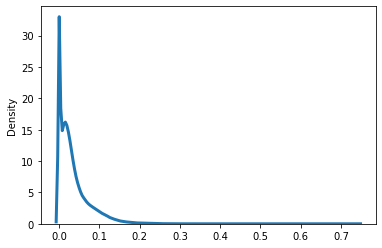

In [21]:
# Try seaborn
sns.distplot(single_refl_array, hist = False, kde = True,
                 kde_kws = {'linewidth': 3})

Let's back up a bit. I'm going to start with the refl_array_df object and filter the dataframe so that it only includes bands that are inside the boxes on the waveform plot above! We know which bands are inside the boxes due to the MicaSense Whitepaper! We want the numbers that fall within the boxes as follows:

1. 444, 472
2. 475, 507
3. 531, 545
4. 560, 587
5. 650, 666
6. 668, 682
7. 705, 715
8. 717, 729
9. 740, 758
10. 842, 899

In [22]:
# Filter for box 1
box_1_df = refl_array_df[refl_array_df["wavelength"].between(444, 472)]

# Check it out
box_1_df

,wavelength,reflectance
13,446.771301,"[[0.0049, 0.0025, 0.0024, 0.0056, 0.0053, 0.01..."
14,451.779297,"[[0.0032, 0.0024, 0.0018, 0.0034, 0.0046, 0.01..."
15,456.787415,"[[0.0038, 0.0029, 0.0027, 0.0037, 0.0045, 0.01..."
16,461.795410,"[[0.0032, 0.0021, 0.0025, 0.0035, 0.0037, 0.01..."
17,466.803406,"[[0.0025, 0.0005, 0.0016, 0.0035, 0.0052, 0.00..."
18,471.811401,"[[0.0034, 0.0025, 0.0019, 0.0023, 0.004, 0.010..."


Success! Now I'm going to separate the values in the reflectance column and put each value in its own row while retaining the wavelength column. The reflectance column is a list of arrays. So below, I explode the reflectance column twice. The first time is to get the arrays out of the list, The second .explode("reflectance") is to then get the values out of the arrays. In other words, the first explode results in a df that has 6000 rows. Remember that each band is a 1000 x 1000 array, and each of those arrays contain 1000 values, that again need separated. Doing the second explode does this, and we are left with a df that has 6,000,000 rows (for 6 bands).

In [23]:
box_1_df_explode = (box_1_df.explode("reflectance")).explode("reflectance")
box_1_df_explode

,wavelength,reflectance
13,446.771301,0.0049
13,446.771301,0.0025
13,446.771301,0.0024
13,446.771301,0.0056
13,446.771301,0.0053
...,...,...
18,471.811401,0.0074
18,471.811401,0.0058
18,471.811401,0.0051
18,471.811401,0.0051


The next step is to plot the frequency distribution of the refelectance for each band, but it seems like I need to have a separate dataframe for each band in order to do this. See this site [here](https://www.geeksforgeeks.org/density-plots-with-pandas-in-python/) and this post [here](https://stackoverflow.com/questions/63258749/how-to-extract-density-function-probabilities-in-python-pandas-kde). So we have to split up the above dataframe into six different dataframes.

In [24]:
# Find unique wavelength values in the dataframe
box_1_wavelength_list = (box_1_df_explode.wavelength.unique()).tolist()
box_1_wavelength_list

[446.77130126953125,
 451.779296875,
 456.78741455078125,
 461.79541015625,
 466.80340576171875,
 471.8114013671875]

In [25]:
# Make a new dataframe for each of those unique wavelength values
box_1_band_1_df = box_1_df_explode[box_1_df_explode.wavelength == box_1_wavelength_list[0]]
box_1_band_1_df

,wavelength,reflectance
13,446.771301,0.0049
13,446.771301,0.0025
13,446.771301,0.0024
13,446.771301,0.0056
13,446.771301,0.0053
...,...,...
13,446.771301,0.0085
13,446.771301,0.0084
13,446.771301,0.0076
13,446.771301,0.0081


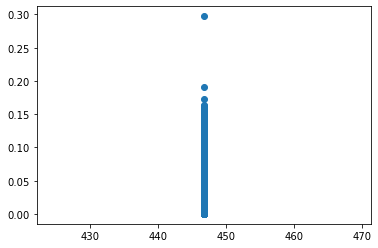

In [26]:
# See the range of reflectance values
plt.scatter(box_1_band_1_df.wavelength, box_1_band_1_df.reflectance)

In [27]:
# Do the same thing for the other 5 bands 
# Could create a function here to loop through the wavelength list
# Band 2
box_1_band_2_df = box_1_df_explode[box_1_df_explode.wavelength == box_1_wavelength_list[1]]

# Band 3
box_1_band_3_df = box_1_df_explode[box_1_df_explode.wavelength == box_1_wavelength_list[2]]

# Band 4
box_1_band_4_df = box_1_df_explode[box_1_df_explode.wavelength == box_1_wavelength_list[3]]

# Band 5
box_1_band_5_df = box_1_df_explode[box_1_df_explode.wavelength == box_1_wavelength_list[4]]

# Band 6
box_1_band_6_df = box_1_df_explode[box_1_df_explode.wavelength == box_1_wavelength_list[5]]

Let's plot the kernel density estimate (kde) now.

Text(0.5, 0, 'Reflectance')

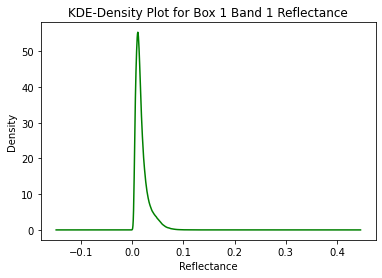

In [28]:
# Box 1 band 1
box_1_band_1_df.reflectance.plot.kde(color="green")
plt.title("KDE-Density Plot for Box 1 Band 1 Reflectance")
plt.xlabel("Reflectance")

It worked, so now let's extract the data from the plot and add a site column so we know what site this data came from.

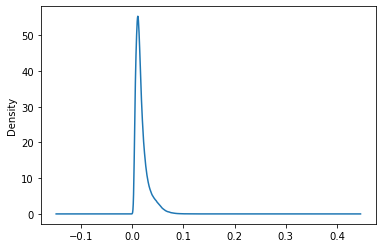

In [29]:
box_1_band_1_kde_arr = box_1_band_1_df.reflectance.plot.kde().get_lines()[0].get_xydata()

The object box_1_band_1_kde_arr contains a lot of arrays. Each array has two values in it, a value for x and a value for y. We need to get all of this information into a pandas dataframe.

In [30]:
box_1_band_1_kde_df = pd.DataFrame(box_1_band_1_kde_arr, columns=list('xy'))
box_1_band_1_kde_df

,x,y
0,-0.148650,0.0
1,-0.148055,0.0
2,-0.147460,0.0
3,-0.146864,0.0
4,-0.146269,0.0
...,...,...
995,0.443569,0.0
996,0.444164,0.0
997,0.444760,0.0
998,0.445355,0.0


In [31]:
# Add band cloumn and site column
box_1_band_1_kde_df["site"] = "NIWO"
box_1_band_1_kde_df["band"] = box_1_wavelength_list[0]

In [32]:
# Check to make sure creating new columns worked
box_1_band_1_kde_df

,x,y,site,band
0,-0.148650,0.0,NIWO,446.771301
1,-0.148055,0.0,NIWO,446.771301
2,-0.147460,0.0,NIWO,446.771301
3,-0.146864,0.0,NIWO,446.771301
4,-0.146269,0.0,NIWO,446.771301
...,...,...,...,...
995,0.443569,0.0,NIWO,446.771301
996,0.444164,0.0,NIWO,446.771301
997,0.444760,0.0,NIWO,446.771301
998,0.445355,0.0,NIWO,446.771301


This is the dataframe that I need to make one ridgeline in the ridgeline plot. I'm going to do what I just did for the rest of the bands in box 1, concat the dataframes, then make the ridgeline figure for box 1. I'll eventually make a function for this.

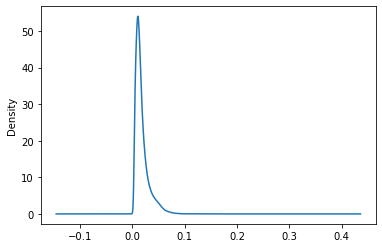

In [33]:
# Band 2
# Get x and y values from kde
box_1_band_2_kde_arr = box_1_band_2_df.reflectance.plot.kde().get_lines()[0].get_xydata()
# Create dataframe from kde x and y values
box_1_band_2_kde_df = pd.DataFrame(box_1_band_2_kde_arr, columns=list('xy'))
# Add band cloumn and site column
box_1_band_2_kde_df["site"] = "NIWO"
box_1_band_2_kde_df["band"] = box_1_wavelength_list[1]

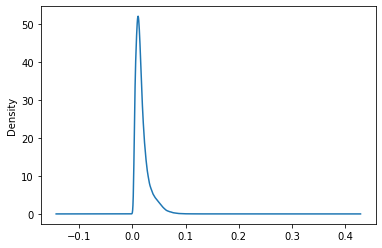

In [34]:
# Band 3
# Get x and y values from kde
box_1_band_3_kde_arr = box_1_band_3_df.reflectance.plot.kde().get_lines()[0].get_xydata()
# Create dataframe from kde x and y values
box_1_band_3_kde_df = pd.DataFrame(box_1_band_3_kde_arr, columns=list('xy'))
# Add band cloumn and site column
box_1_band_3_kde_df["site"] = "NIWO"
box_1_band_3_kde_df["band"] = box_1_wavelength_list[2]

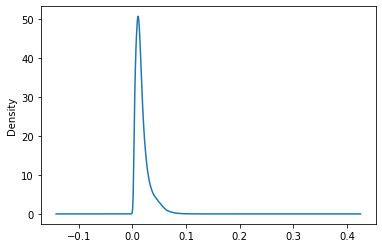

In [35]:
# Band 4
# Get x and y values from kde
box_1_band_4_kde_arr = box_1_band_4_df.reflectance.plot.kde().get_lines()[0].get_xydata()
# Create dataframe from kde x and y values
box_1_band_4_kde_df = pd.DataFrame(box_1_band_4_kde_arr, columns=list('xy'))
# Add band cloumn and site column
box_1_band_4_kde_df["site"] = "NIWO"
box_1_band_4_kde_df["band"] = box_1_wavelength_list[3]

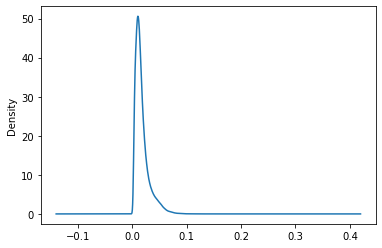

In [36]:
# Band 5
# Get x and y values from kde
box_1_band_5_kde_arr = box_1_band_5_df.reflectance.plot.kde().get_lines()[0].get_xydata()
# Create dataframe from kde x and y values
box_1_band_5_kde_df = pd.DataFrame(box_1_band_5_kde_arr, columns=list('xy'))
# Add band cloumn and site column
box_1_band_5_kde_df["site"] = "NIWO"
box_1_band_5_kde_df["band"] = box_1_wavelength_list[4]

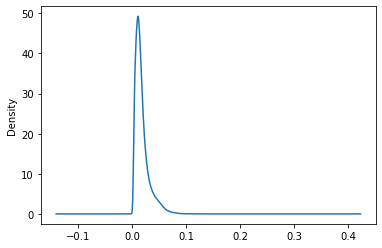

In [37]:
# Band 6
# Get x and y values from kde
box_1_band_6_kde_arr = box_1_band_6_df.reflectance.plot.kde().get_lines()[0].get_xydata()
# Create dataframe from kde x and y values
box_1_band_6_kde_df = pd.DataFrame(box_1_band_6_kde_arr, columns=list('xy'))
# Add band cloumn and site column
box_1_band_6_kde_df["site"] = "NIWO"
box_1_band_6_kde_df["band"] = box_1_wavelength_list[5]

In [38]:
# Add all dataframes together
box_1_kde_df = pd.concat([box_1_band_1_kde_df,
                         box_1_band_2_kde_df,
                         box_1_band_3_kde_df,
                         box_1_band_4_kde_df,
                         box_1_band_5_kde_df,
                         box_1_band_6_kde_df])

In [39]:
# Check out output to make sure it worked
box_1_kde_df

,x,y,site,band
0,-0.148650,0.0,NIWO,446.771301
1,-0.148055,0.0,NIWO,446.771301
2,-0.147460,0.0,NIWO,446.771301
3,-0.146864,0.0,NIWO,446.771301
4,-0.146269,0.0,NIWO,446.771301
...,...,...,...,...
995,0.420443,0.0,NIWO,471.811401
996,0.421008,0.0,NIWO,471.811401
997,0.421572,0.0,NIWO,471.811401
998,0.422136,0.0,NIWO,471.811401


The cell below is taking too long to run. I haven't been able to see the output yet. I followed the tutorial [here](https://seaborn.pydata.org/examples/kde_ridgeplot.html). Here, I'm using the box_1_df_explode because the code below is making the density plots, so I don't need to plot the kde and extract those values.

In [40]:
# # we generate a color palette with Seaborn.color_palette()
# pal = sns.color_palette(palette="coolwarm", n_colors=6)

# # in the sns.FacetGrid class, the "hue" argument is the one that is the one 
# # that will be represented by colors with "palette"
# g = sns.FacetGrid(box_1_df_explode, col="wavelength", hue="wavelength", aspect=15, height=0.75, palette=pal)

# # then we add the densities kdeplots for each band
# g.map(sns.kdeplot, 'reflectance',
#       bw_adjust=1, clip_on=False,
#       fill=True, alpha=1, linewidth=1.5)

Now I'm going to try to make a ridgeline plot using matplotlib following the tutorial [here](https://matplotlib.org/matplotblog/posts/create-ridgeplots-in-matplotlib/).

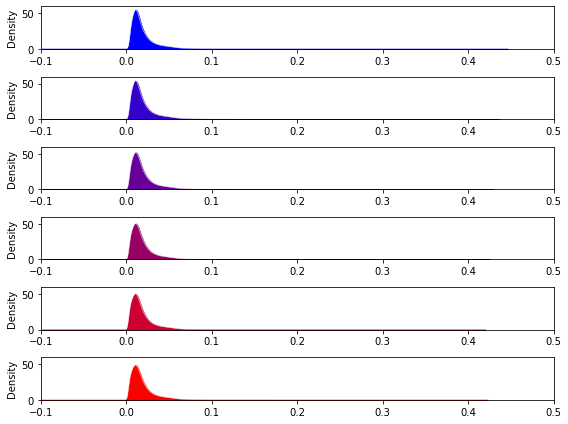

In [41]:
# List of wavelengths from box 1
box_1_wavelength_list

# Colors for each band
colors = ['#0000ff', '#3300cc', '#660099', '#990066', '#cc0033', '#ff0000']

gs = (grid_spec.GridSpec(len(box_1_wavelength_list),1))

fig = plt.figure(figsize=(8,6))

i = 0

#creating empty list
ax_objs = []

for wavelength in box_1_wavelength_list:
    # creating new axes object and appending to ax_objs
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    # plotting the distribution
    plot = (box_1_df_explode[box_1_df_explode.wavelength == wavelength]
            .reflectance.plot.kde(ax=ax_objs[-1],color="#f0f0f0", lw=0.5))

    # grabbing x and y data from the kde plot
    x = plot.get_children()[0]._x
    y = plot.get_children()[0]._y

    # filling the space beneath the distribution
    ax_objs[-1].fill_between(x,y,color=colors[i])

    # setting uniform x and y lims
    ax_objs[-1].set_xlim(-0.1, 0.5)
    ax_objs[-1].set_ylim(0, 60)

    i += 1

plt.tight_layout()
plt.show()

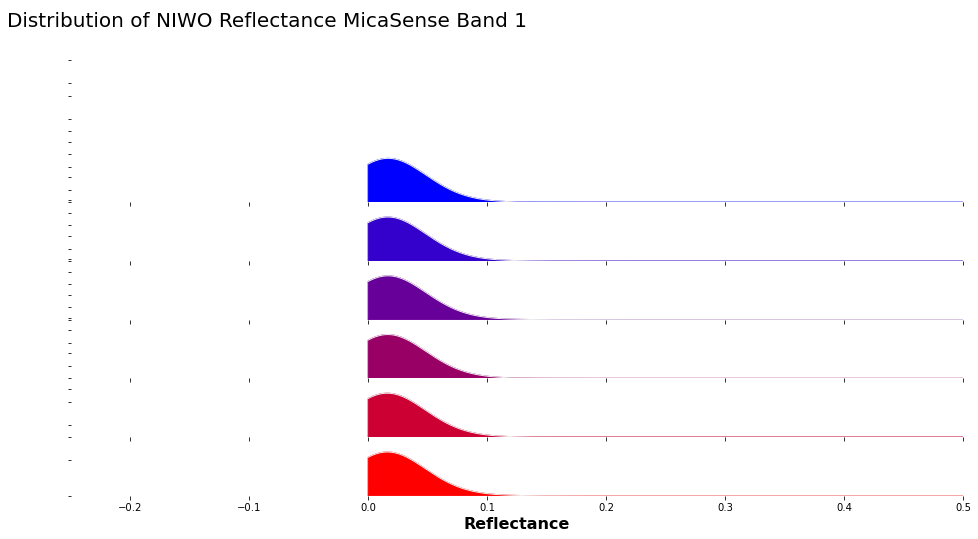

In [42]:
# List of wavelengths from box 1
box_1_wavelength_list

# Colors for each band
colors = ['#0000ff', '#3300cc', '#660099', '#990066', '#cc0033', '#ff0000']

gs = grid_spec.GridSpec(len(box_1_wavelength_list),1)
fig = plt.figure(figsize=(16,9))

i = 0

ax_objs = []
for wavelength in box_1_wavelength_list:
    wavelength = box_1_wavelength_list[i]
    # I think this is putting the reflectance values back into an array, which
    # is what box_1_df is
    x = np.array(box_1_df_explode[box_1_df_explode.wavelength == wavelength].reflectance)
    x_d = np.linspace(0,1, 1000)

    kde = KernelDensity(bandwidth=0.03, kernel='gaussian')
    kde.fit(x[:, None])

    logprob = kde.score_samples(x_d[:, None])

    # creating new axes object
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    # plotting the distribution
    ax_objs[-1].plot(x_d, np.exp(logprob),color="#f0f0f0",lw=1)
    ax_objs[-1].fill_between(x_d, np.exp(logprob), alpha=1,color=colors[i])


    # setting uniform x and y lims
    ax_objs[-1].set_xlim(-0.25, 0.5)
    ax_objs[-1].set_ylim(0, 55)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])

    if i == len(box_1_wavelength_list)-1:
        ax_objs[-1].set_xlabel("Reflectance", fontsize=16,fontweight="bold")
    else:
        ax_objs[-1].set_xticklabels([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

#     adj_wavelength = wavelength.replace(" ","\n")
#     ax_objs[-1].text(-0.02,0,adj_wavelength,fontweight="bold",fontsize=14,ha="right")


    i += 1

gs.update(hspace=-0.7)

fig.text(0.07,0.85,"Distribution of NIWO Reflectance MicaSense Band 1",fontsize=20)

plt.show()


These last two methods work, but the denisty from band to band look very similar, if not the same, which I don't think is correct. This is the same thing that was happening when I used joypy to make a ridgeline plot. 